## Data Wrangling a la base de datos

In [1]:
# !pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
import seaborn as sns
import re

import warnings
warnings.simplefilter("ignore")

In [3]:
dta = pd.read_csv("./data/dta.csv", delimiter=";", index_col="Unnamed: 0", usecols=["Unnamed: 0","article_name", "authors", "volume_name", "volumen_date"])

dta.head()

,article_name,authors,volume_name,volumen_date
0,Editorial Board,[],Volume 74,December 2022
1,Congestion in a public health service: A macro...,"['[Kelly, Mark]', '[Kuhn, Michael]']",Volume 74,December 2022
2,The wage dispersion effects of international m...,"['[Sargent, Kristina]']",Volume 74,December 2022
3,Balanced-budget rules and macroeconomic stabil...,"['[Guo, Jang-Ting]', '[Zhang, Yan]']",Volume 74,December 2022
4,Illiquid investments and the non-monotone rela...,"['[Salas, Sergio]', '[Odell, Kathleen]']",Volume 74,December 2022


Eliminando algunos archivos que no tienen autores, y que posiblemente sean anuncios o portadas

In [4]:
dta.drop(dta[dta["authors"] == "[]"].index, inplace=True)

Renombraré observaciones de la columnas `volumen_date` que contengan informacion irrelevante al igual que en `volume_date`

In [5]:
dta["volumen_date"] = dta["volumen_date"].str.replace(r'[^(]*\(|\)[^)]*', '')
dta["volume_name"] = dta["volume_name"].str.split(',').str[0]

Creando años de publicacion `year`

In [6]:
dta["year"] = dta["volumen_date"].str.split().str[-1]

Creacion de `keywords`

In [7]:
dta["keywords"] = dta["article_name"].str.lower()

# Eliminar palabras
words = [
    "in", "a", "the", "of", "as", "with", "its",
    "their", "and", "vs.", "non", "for", "is",
    "from", "an", "to", "on", "or", "are", "can",
    "at", "do", "does", "by"
]

dta["keywords"] = dta["keywords"].str.replace(r"\s*(?<!\w)(?:{})(?!\w)".format("|".join([re.escape(x) for x in words])), " ")

# Eliminar caracteres
characters = [
    ":", ",", ".", ";", '“','”',"'"
]

for c in characters:
     dta["keywords"] = dta["keywords"].str.replace(c, '')

# Palabras a lista
dta["keywords"] = dta["keywords"].str.replace(r'\s+', ' ', regex=True)
dta["keywords"] = dta["keywords"].str.strip()
dta["keywords"] = [x.split(" ") for x in dta["keywords"]]

# Eliminando el titulo
dta.drop(["article_name"], axis=1, inplace=True)

Modificaciones finales a `authors`

In [8]:
dta["authors"] = dta["authors"].str[1:]
dta["authors"] = dta["authors"].str[:-1]
dta["authors"] = dta["authors"].str.replace("'", "")

In [9]:
dta.head()

,authors,volume_name,volumen_date,year,keywords
1,"[Kelly, Mark], [Kuhn, Michael]",Volume 74,December 2022,2022,"[congestion, public, health, service, macro, a..."
2,"[Sargent, Kristina]",Volume 74,December 2022,2022,"[wage, dispersion, effects, international, mig..."
3,"[Guo, Jang-Ting], [Zhang, Yan]",Volume 74,December 2022,2022,"[balanced-budget, rules, macroeconomic, stabil..."
4,"[Salas, Sergio], [Odell, Kathleen]",Volume 74,December 2022,2022,"[illiquid, investments, -monotone, relationshi..."
5,"[Kasuga, Hidefumi], [Morita, Yuichi]",Volume 74,December 2022,2022,"[health, gap, effect, economic, outcomes]"


## Estadísticas

In [10]:
print(f"La base de datos contiene {dta.shape[0]} filas y {dta.shape[1]} columnas")

La base de datos contiene 2323 filas y 5 columnas


In [11]:
print("El TOP 10 de mayor cantidad de publicaciones por fecha es:")
print("")
dta["volumen_date"].value_counts()[0:10]

El TOP 10 de mayor cantidad de publicaciones por fecha es:



March 2014        41
December 2013     38
March 2010        35
March 2008        31
December 2019     29
September 2008    29
June 2014         28
September 2015    27
December 2008     26
June 2019         26
Name: volumen_date, dtype: int64

In [12]:
print("El TOP 10 de mayor cantidad de publicaciones por volumen es:")
print("")
dta[["volume_name"]].value_counts()[0:10]

El TOP 10 de mayor cantidad de publicaciones por volumen es:



volume_name
Volume 30      108
Volume 32       86
Volume 34       83
Volume 33       61
Volume 31       57
Volume 29       53
Volume 9        53
Volume 28       50
Volume 16       44
Volume 26       44
dtype: int64

In [13]:
print("El TOP 10 de mayor cantidad de publicaciones por año es:")
print("")
dta[["year"]].value_counts()[0:10]

El TOP 10 de mayor cantidad de publicaciones por año es:



year
2008    108
2014    104
2015     95
2013     91
2019     89
2010     86
2012     83
2016     82
2018     81
2017     66
dtype: int64

## Visualizaciones

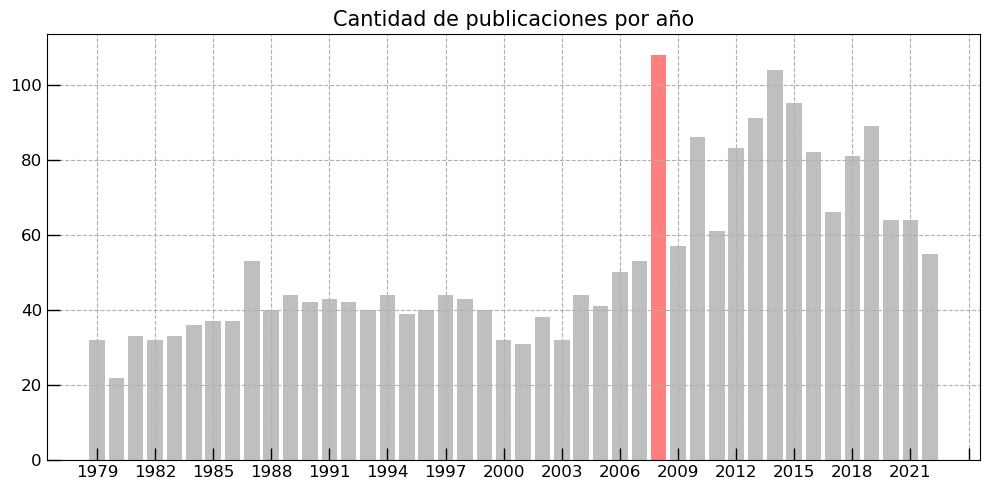

In [14]:
publication_per_year = dta[["year", "volumen_date"]].groupby("year").count()
colors = ["red" if index == "2008" else "gray" for index in publication_per_year.index]


fig, ax = plt.subplots(figsize=(10,5))

fig = plt.bar(
    x=publication_per_year.index, height=publication_per_year.volumen_date,
    color=colors, alpha=0.5
)


plt.title("Cantidad de publicaciones por año", fontsize=15)
plt.xlabel("")
plt.grid(linestyle='--')
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.tight_layout()

plt.savefig("./figures/bar-publicaciones-year.pdf")
plt.savefig("./figures/bar-publicaciones-year.png")
plt.show()

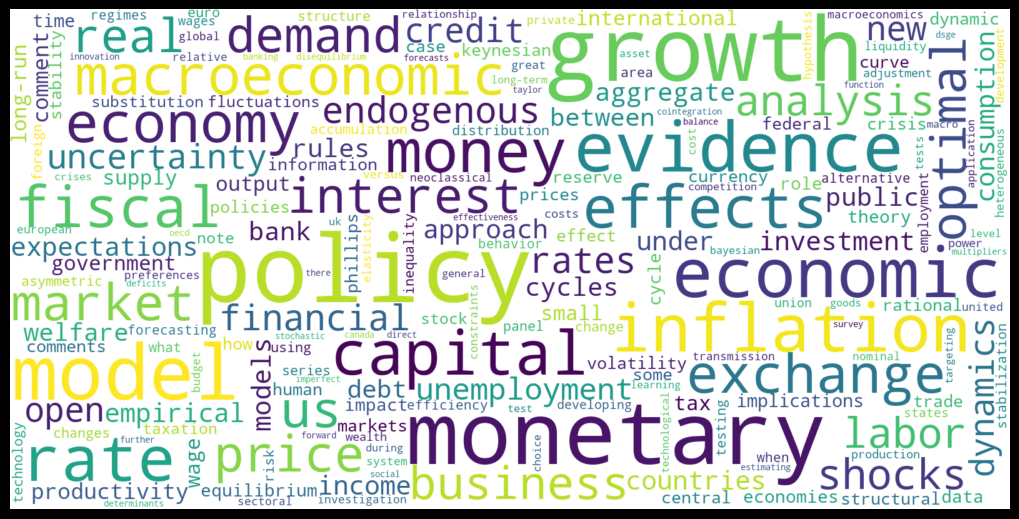

In [15]:
words_per_year = dta.explode("keywords")[["year", "keywords"]]

text = words_per_year["keywords"].value_counts().to_dict()
wordcloud = WordCloud(width=1600, height=800, max_font_size=150, max_words=200, background_color="white").generate_from_frequencies(text)


plt.figure(figsize=(10,5), facecolor='k')

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.savefig("./figures/wordcloud-keywords.pdf")
plt.savefig("./figures/wordcloud-keywords.png")
plt.show()

In [16]:
{k: text[k] for k in list(text)[:10]}

{'policy': 336,
 'growth': 299,
 'monetary': 292,
 'model': 219,
 'evidence': 175,
 'economic': 174,
 'inflation': 166,
 'rate': 146,
 'capital': 136,
 'money': 133}

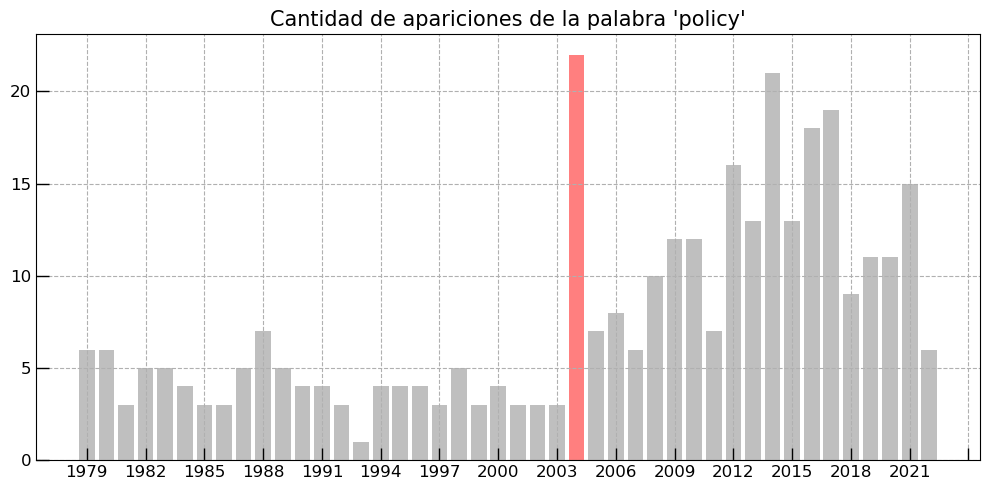

In [17]:
policy_per_year = words_per_year[words_per_year["keywords"] == "policy"]
policy_per_year = policy_per_year.groupby("year").count()

colors = ["red" if index == "2004" else "gray" for index in policy_per_year.index]


fig, ax = plt.subplots(figsize=(10,5))

fig = plt.bar(
    x=policy_per_year.index, height=policy_per_year.keywords,
    color=colors, alpha=0.5
)


plt.title("Cantidad de apariciones de la palabra 'policy'", fontsize=15)
plt.xlabel("")
plt.grid(linestyle='--')
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.tight_layout()

plt.savefig("./figures/bar-policy-year.pdf")
plt.savefig("./figures/bar-policy-year.png")
plt.show()

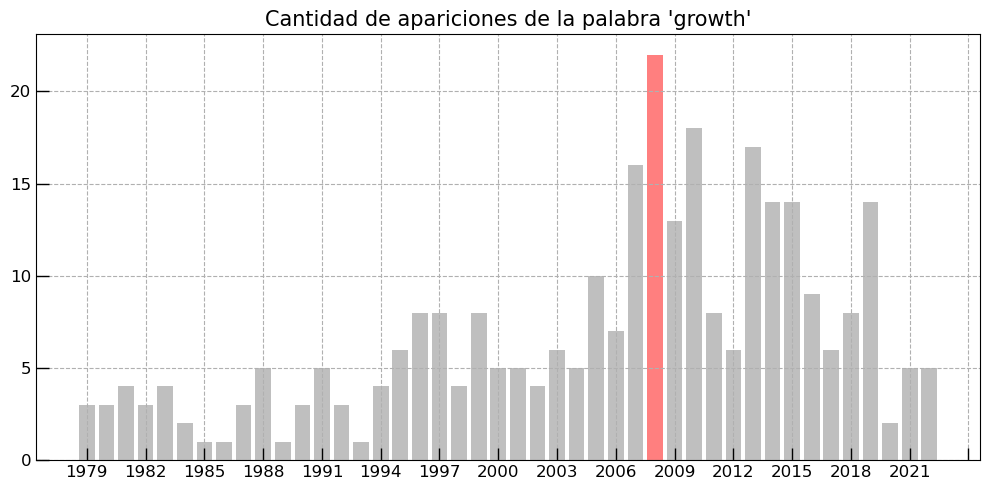

In [18]:
growth_per_year = words_per_year[words_per_year["keywords"] == "growth"]
growth_per_year = growth_per_year.groupby("year").count()

colors = ["red" if index == "2008" else "gray" for index in growth_per_year.index]


fig, ax = plt.subplots(figsize=(10,5))

fig = plt.bar(
    x=growth_per_year.index, height=growth_per_year.keywords,
    color=colors, alpha=0.5
)


plt.title("Cantidad de apariciones de la palabra 'growth'", fontsize=15)
plt.xlabel("")
plt.grid(linestyle='--')
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.tight_layout()

plt.savefig("./figures/bar-growth-year.pdf")
plt.savefig("./figures/bar-growth-year.png")
plt.show()

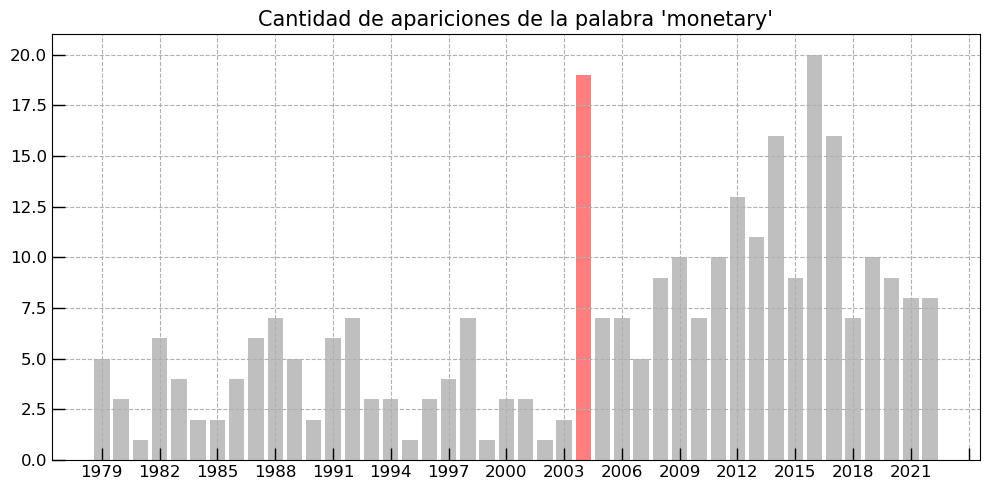

In [19]:
monetary_per_year = words_per_year[words_per_year["keywords"] == "monetary"]
monetary_per_year = monetary_per_year.groupby("year").count()

colors = ["red" if index == "2004" else "gray" for index in monetary_per_year.index]


fig, ax = plt.subplots(figsize=(10,5))

fig = plt.bar(
    x=monetary_per_year.index, height=monetary_per_year.keywords,
    color=colors, alpha=0.5
)


plt.title("Cantidad de apariciones de la palabra 'monetary'", fontsize=15)
plt.xlabel("")
plt.grid(linestyle='--')
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.tight_layout()

plt.savefig("./figures/bar-monetary-year.pdf")
plt.savefig("./figures/bar-monetary-year.png")
plt.show()

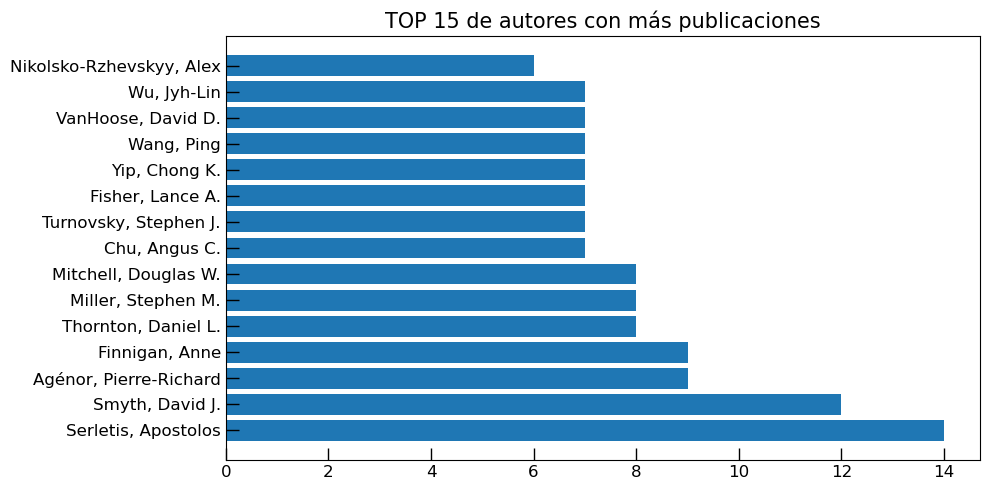

In [20]:
# Separando autores
authors = dta["authors"].values.tolist()
authors = [x.split("], ") for x in authors]
authors = sum(authors, [])

# Limpiando elementos
authors = [s.replace("[", "") for s in authors]
authors = [s.replace("]", "") for s in authors]

# Agrupando
publication_per_author = {x:authors.count(x) for x in authors}
publication_per_author = dict(sorted(publication_per_author.items(), key=lambda item: item[1], reverse=True))

# TOP 20
publication_per_author = {k: publication_per_author[k] for k in list(publication_per_author)[:15]}
y = publication_per_author.keys()
x = publication_per_author.values()


pos = np.arange(15)+.5

fig, ax = plt.subplots(figsize=(10,5))
fig = plt.barh(pos, x, align = 'center')
plt.yticks(pos, y)

plt.title("TOP 15 de autores con más publicaciones", fontsize=15)
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.tight_layout()

plt.savefig("./figures/barh-authors.pdf")
plt.savefig("./figures/barh-authors.png")
plt.show()